### PYTORCH COMPUTER VISION

In [1]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 19.6 MB/s eta 0:00:00


In [76]:

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torchmetrics import ConfusionMatrix

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer
from tqdm.autonotebook import tqdm
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import pickle


torch.__version__

'2.5.1+cu121'

### SETUP DEVICE AGNOSTIC CODE

In [3]:
!nvidia-smi 2>&1 | grep -i "cuda"


| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |


In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### IMPORTING DATA SET

In [5]:
#FashionMNIST dataset

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = ToTensor(), target_transform = None)
train_data

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.4MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = ToTensor(), target_transform = None)
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = ToTensor(), target_transform = None)

### DATA VISUALIZATION

In [8]:
image, label = train_data[0] # label = 9

class_names = train_data.classes
class_to_idx = train_data.class_to_idx

targets = train_data.targets



In [9]:
print("Image shape: ", image.shape)
print("Label : ", label)
print("Class label: ", class_to_idx)

Image shape:  torch.Size([1, 28, 28])
Label :  9
Class label:  {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


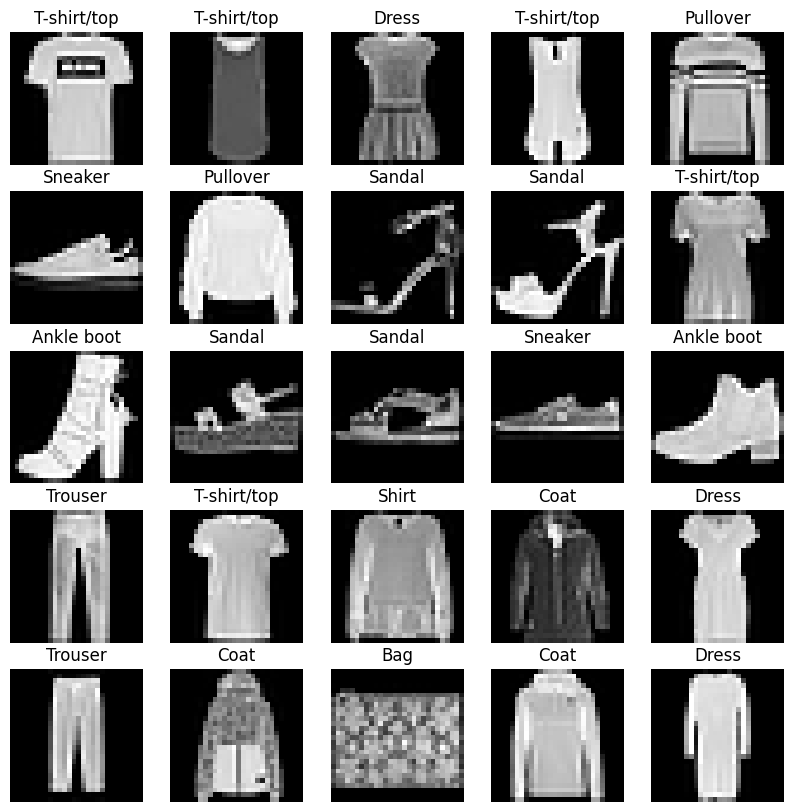

In [10]:
torch.manual_seed(42)

row = 5
col = 5

fig = plt.figure(figsize = (10,10))

for idx in range(1, row*col+1):

  random_tensor = torch.randint(0, 6000, size=(1,), dtype = torch.int32)

  image, label = train_data[idx]
  image = image.reshape(28,28,1)
  fig.add_subplot(row,col,idx)
  plt.title(class_names[label])
  plt.imshow(image, cmap = 'gray')
  plt.axis(False)


### PREPARE DATALOADER

In [11]:
# Prepare dataloader
BATCH_SIZE = 32

'''
torch.utils.data. DataLoader:
  Parameters:
    dataset : Dataset of the problem
    batch_size : int
    shuffle : True/False
'''

train_loader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)




In [12]:
#Get a batch from loader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

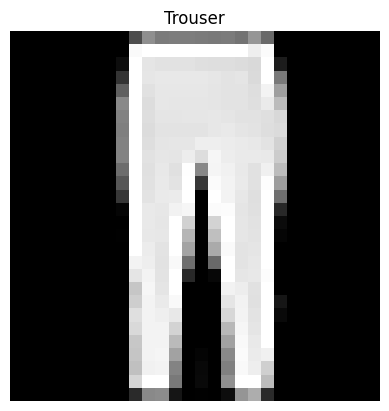

In [14]:

idx = torch.randint(0, len(train_features_batch), size=(1,), dtype = torch.int32)

image, label = train_features_batch[idx], train_labels_batch[idx]
image = image.reshape(28,28,1)
plt.title(class_names[label])
plt.imshow(image, cmap = 'gray')
plt.axis(False)


### BUILD A BASELINE MODEL

In [15]:
# Build a baseline model

In [16]:
#Create a flatten layer

'''
nn.Flatten :
  Convert 2d image to 1d : (height, width, chanel) -> (height*width, chanel)
'''
flatten_model = nn.Flatten()

#Demo flatten layer
x = train_features_batch[0]
output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [17]:
#Create first model

class FashionModel_0(nn.Module):
  def __init__(self, input_shape : int, output_shape : int):
      super().__init__()
      self.layer_stack = nn.Sequential (
          nn.Flatten(),
          nn.Linear(in_features = input_shape, out_features = 32),
          nn.ReLU(),
          nn.Linear(in_features = 32, out_features = 64),
          nn.Tanh(),
          nn.Linear(in_features = 64, out_features = 32),
          nn.ReLU(),
          nn.Linear(in_features = 32, out_features = output_shape)
      )
  def forward(self, x):
    return self.layer_stack(x)

In [18]:
#Create model instance
torch.manual_seed(42)

model_0 = FashionModel_0(input_shape = 784, output_shape = len(class_names) ).to(device)
model_0

FashionModel_0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): Tanh()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [19]:
#Setup loss function and optimizer

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)

def accuracy_function(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_true)) * 100

In [20]:
with torch.inference_mode():
  y_logits = model_0(train_features_batch.to(device))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

accuracy_function(y_pred, train_labels_batch.to(device))



9.375

### TRACK PERFORMANCE TIME OF A MODEL

In [21]:
def train_time(start : float, end : float, device : torch.device = None):
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} secs")
  return total_time

start = timer()
#Start training here
end = timer()

train_time(start,end, device)

Train time on cuda : 0.000 secs


4.9974000035035715e-05

### CREATE TRAINING LOOP

In [22]:
'''
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate train loss
3. Loop through testing batches, calculate test loss, accuracy
4. Print information
5. Time it
'''

torch.manual_seed(42)

train_time_start = timer()

epochs = 3

#Loop through epochs
for epoch in tqdm(range(epochs)):

  print(f"----------Epoch {epoch}----------")
  train_loss = 0

  #Loop through every batches in loader
  for batch, (X_train, y_train) in enumerate(train_loader):

    model_0.train()

    #Forward pass
    y_logits = model_0(X_train.to(device))

    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)

    #Calculate loss
    loss = loss_function(y_logits,y_train.to(device))
    train_loss += loss

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

  #Evaluation
  model_0.eval()
  test_loss = 0
  test_accuracy = 0

  with torch.inference_mode():
    for X_test, y_test in test_loader:
      #Get prediction
      test_logits = model_0(X_test.to(device))
      test_predict = torch.softmax(test_logits, dim = 1).argmax(dim=1)

      #Calculate loss
      test_loss += loss_function(test_logits, y_test.to(device))

      #Calculate accuracy
      test_accuracy += accuracy_function(test_predict, y_test.to(device))

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    train_loss = train_loss / len(train_loader)

    print(f"Train loss : {train_loss:.3f} | Test loss : {test_loss:.3f} | Test accuracy : {test_accuracy:.3f}\n")
train_time_end = timer()

model_0_train_time = train_time(start= train_time_start, end = train_time_end, device = device)


  0%|          | 0/3 [00:00<?, ?it/s]

----------Epoch 0----------
Train loss : 0.583 | Test loss : 0.522 | Test accuracy : 81.490

----------Epoch 1----------
Train loss : 0.509 | Test loss : 0.527 | Test accuracy : 81.180

----------Epoch 2----------
Train loss : 0.500 | Test loss : 0.534 | Test accuracy : 80.831

Train time on cuda : 34.443 secs


### MODEL EVALUATION

In [23]:
def eval_model(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_function : torch.nn.Module,
               accuracy_function
               ):
  loss = 0
  accuracy = 0
  with torch.inference_mode():
    for X_eval, y_eval in data_loader:
      eval_logits = model(X_eval.to(device))
      eval_pred = torch.softmax(eval_logits, dim=1).argmax(dim = 1)

      loss += loss_function(eval_logits, y_eval.to(device))

      accuracy += accuracy_function(eval_pred, y_eval.to(device))
    loss /= len(data_loader)
    accuracy /= len(data_loader)

  return {"model_name" : model.__class__.__name__,
          "model_loss" : loss.item(),
          "model_accuracy" : accuracy}


In [24]:
model_0_result = eval_model(model=model_0, data_loader = test_loader, loss_function = loss_function, accuracy_function = accuracy_function)

model_0_result

{'model_name': 'FashionModel_0',
 'model_loss': 0.534152090549469,
 'model_accuracy': 80.83067092651757}

### CONVOLUTIONAL NEURON NETWORK

In [25]:
#Create a convolutional neural network
'''
nn.Conv2D:  Convolutional layer
  Parameters:
    in_chansels (int): input shape
    out_chansels (int): output shape
    kernal_size (int): size of the convolving window
    stride (int): stride of the convolution opperation
    padding (int): padding zero pixel around the input
    bias (bool) : Add a bias value while learning
'''

'''
nn.MaxPool2D : Max pooling layer
  Parameters:
    kernal_size : size of max pooling window
    stride (int) : strid of the max pooling operation
    padding (int) : padding zero pixels around
'''

class CNN_FashionModel(nn.Module):
  def __init__(self, input_shape : int, output_shape : int,  hidden_units : int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer_1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7 *7, out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.layer_1(x)
    # print(x.shape)
    return x



In [26]:
#Get model instance

torch.manual_seed(42)

cnn_model = CNN_FashionModel(input_shape = 1, output_shape = len(class_names), hidden_units = 64).to(device) #Input shape = number of color chanel

cnn_model

CNN_FashionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)

In [27]:
#Test on a random tensor with the size of the input data

random_tensor = torch.randn(size = (1,28,28))

random_tensor = random_tensor.unsqueeze(0).to(device)
random_tensor.shape

torch.Size([1, 1, 28, 28])

In [28]:
cnn_model(random_tensor)

tensor([[-0.0098, -0.0218,  0.0137,  0.0146,  0.0285,  0.0176, -0.0169, -0.0015,
         -0.0949,  0.0560]], device='cuda:0', grad_fn=<AddmmBackward0>)

### ABOUT CONVOLUTIONAL LAYER

In [29]:
#Create dummy data

torch.manual_seed(42)

images = torch.randn(size = (32,3,64,64))
test_image = images[0]

print(images.shape, test_image.shape)

torch.Size([32, 3, 64, 64]) torch.Size([3, 64, 64])


In [30]:
#Create a single convolution layer

convolution_layer = nn.Conv2d(in_channels=3,out_channels = 10, kernel_size = (3,3), stride = 1, padding=0)

output = convolution_layer(test_image)

output.shape

torch.Size([10, 62, 62])

### ABOUT MAX POOLING LAYER

In [31]:
test_image.shape

torch.Size([3, 64, 64])

In [32]:
#Create a max pooling layer
max_pooling_layer = nn.MaxPool2d(kernel_size = 2)

output = max_pooling_layer(test_image)

output.shape # Image shape reduced

torch.Size([3, 32, 32])

### SETUP AND TRAIN FOR CNN


In [33]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = cnn_model.parameters(), lr = 0.01)

In [34]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

train_time_start = timer()
for epoch in tqdm(range(epochs)):
  print("Epoch: ",epoch)

  train_step(model = cnn_model, data_loader = train_loader, loss_fn = loss_function, optimizer = optimizer, accuracy_fn = accuracy_function, device = device)

  test_step(model = cnn_model, data_loader = test_loader, loss_fn = loss_function, accuracy_fn = accuracy_function, device = device)
train_time_end = timer()

cnn_train_time = train_time(start= train_time_start, end = train_time_end, device = device)




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:  0
Train loss: 0.85089 | Train accuracy: 69.81%
Test loss: 0.50838 | Test accuracy: 81.84%

Epoch:  1
Train loss: 0.44992 | Train accuracy: 83.72%
Test loss: 0.41831 | Test accuracy: 84.47%

Epoch:  2
Train loss: 0.38534 | Train accuracy: 86.18%
Test loss: 0.37677 | Test accuracy: 86.30%

Train time on cuda : 39.328 secs


In [36]:
cnn_model_result = eval_model(model = cnn_model, data_loader=test_loader, accuracy_function = accuracy_function, loss_function=loss_function)
cnn_model_result

{'model_name': 'CNN_FashionModel',
 'model_loss': 0.3767710030078888,
 'model_accuracy': 86.30191693290735}

### COMPARE MODEL RESULT AND TRAINING TIME


In [37]:
results_df = pd.DataFrame( [model_0_result, cnn_model_result])
results_df

,model_name,model_loss,model_accuracy
0,FashionModel_0,0.534152,80.830671
1,CNN_FashionModel,0.376771,86.301917


In [38]:
results_df['training_time'] = [model_0_train_time, cnn_train_time]
results_df

,model_name,model_loss,model_accuracy,training_time
0,FashionModel_0,0.534152,80.830671,34.443135
1,CNN_FashionModel,0.376771,86.301917,39.328351


In [39]:
def make_predictions(model: torch.nn.Module, data: list, device:torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)


In [40]:
random.seed(42)

test_samples = []
test_labels = []

for sample, label  in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

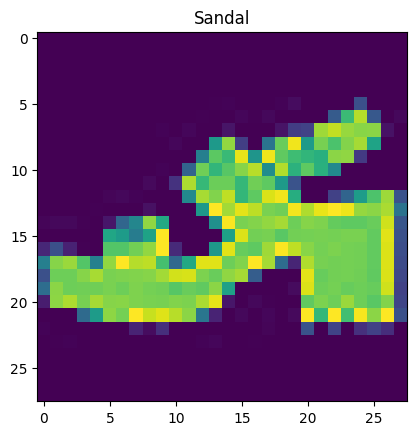

In [41]:
plt.imshow(test_samples[0].squeeze())
plt.title(class_names[test_labels[0]])

In [42]:
#Make prediction

pred_probs = make_predictions(model=cnn_model, data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

PLOTTING PREDICTION ON RANDOM SAMPLES

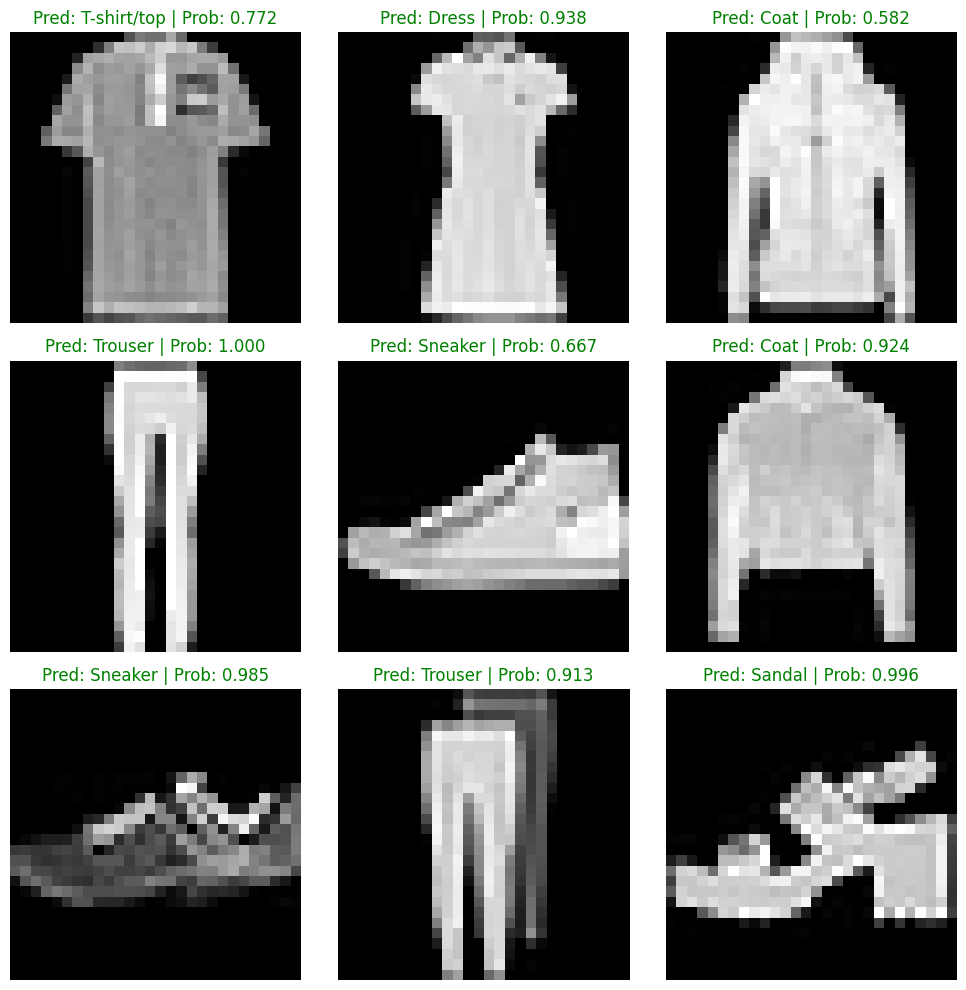

In [75]:
plt.figure(figsize=(10, 10))
n_rows = 3
n_cols = 3
n_images = n_rows * n_cols
random_indices = np.random.choice(len(test_samples), n_images, replace=False)

for i, idx in enumerate(random_indices):
    sample, label = test_samples[idx], test_labels[idx]
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_prob, pred_label = pred_probs[idx], pred_classes[idx]
    color = "green" if pred_label == label else "red"
    plt.title(
        f"Pred: {class_names[pred_label]} | Prob: {pred_prob[pred_label]:.3f}",
        color=color,
    )
    plt.axis(False)

plt.tight_layout()
plt.show()

### SAVING MODEL

In [77]:
# Save the model into pkl file
with open("cnn_model.pkl", "wb") as f:
  pickle.dump(cnn_model, f)
